In [23]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

import scipy


Loading BokehJS ...

# Functions

In [19]:
def initialize_parameters(par = np.array([0.5, 0.9, 0, 1, 0])):
    # np.random.seed(3)
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])    # one way to choose that is omega/(1-beta) = unconditional mean 
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   # one way to choose is unconditional mean 

    return parameters

def loglik(y, f, x, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2 
    return ll


def score_compute(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f)/sigma
    # score = (y - x*f)
    
    return score

def filterGAS(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

In [20]:
def score_compute_2(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f) # ** The 'type = 2' modification **
    
    return score

def filterGAS_2(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute_2(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute_2(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest_2(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS_2(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

In [21]:
def GAS_est(df):
    
    y = df.net_qty.values          # observed demand (response)
    x = df.buy_availability.values # buy_availability (explanatory)

    y = y.reshape((len(y),1)) 
    x = x.reshape((len(y),1))
    
    ret = pd.DataFrame()
    ret['year'] = df['year']
    ret['week'] = df['week']
        
    abc = scipy.optimize.minimize(
        loglikest,                                       # function to minimize (log likelihood y|x,theta)
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), # initial parameter values (starting)
        args=(y, x), 
        options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
        method='L-BFGS-B', 
        bounds=((0,  None),             # alpha
                (-1, 1),                # beta
                (0.001, np.mean(y)*2),  # omega 
                (0.001, None),          # sigma
                (0.001, np.mean(y)*2)   # f
               )
    )
    
    
    # --- CONVERGENCE control flow ---
    if abc.success == True:
        
        x1par = initialize_parameters(abc.x) 
        f_est = filterGAS(y, x, x1par)
        
        ret['f_est'] = f_est 
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['One'] * len(y)
        
    # **Modification if first algorithm fails
    elif abc.success == False:
        
        abc = scipy.optimize.minimize(
            loglikest_2,                                       # function to minimize (log likelihood y|x,theta)
            np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]),   # initial parameter values (starting)
            args=(y, x), 
            options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
            method='L-BFGS-B', 
            bounds=((0,  None),             # alpha
                    (-1, 1),                # beta
                    (0.001, np.mean(y)*2),  # omega 
                    (0.001, None),          # sigma
                    (0.001, np.mean(y)*2)   # f
                   )
                )

        x1par = initialize_parameters(abc.x) 
        f_est = filterGAS_2(y, x, x1par)
        
        ret['f_est'] = f_est 
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['Two'] * len(y)

    return ret

## Data

In [3]:
dat0 = pd.read_csv('data/ch4k_df_eu.csv')

ref_dat0 = pd.read_csv('data/dat_ref.csv', low_memory = False, index_col = 0,
                     usecols = ['group_article', 'price_band', 'age_group_descr', 
                                'brand_descr', 'sub_brand_descr',
                                'rmh_retail_department_descr', 'rmh_category_descr', 'rmh_gender_descr',
                                'rmh_retail_section_descr', 'rmh_product_division_descr',
                                'rmh_product_type_descr', 'product_franchise_descr'])

In [5]:
dat = dat0.copy()

dat.dropna(inplace = True)

dat = dat[(dat.season_net_qty > 250) &
          (dat.country == 'EU')]

ref_dat = ref_dat0.copy()

ref_dat = ref_dat.reset_index().drop_duplicates()[['group_article', 'rmh_product_type_descr']]
dat = pd.merge(dat, ref_dat, left_on='article_number', right_on='group_article', how = 'left')

key = {'FW16': 1, 'SS17': 2, 'FW17': 3, 'SS18': 4, 'FW18': 5, 'SS19': 6, 'FW19': 7, 'SS20': 8}
dat['order_key'] = [key[s] for s in dat.season]

In [6]:
dat.head()

,article_number,brand,year,week,country,season,gross_demand_quantity,net_qty,clearance,margin,season_gross_demand_quantity,season_net_qty,buy_availability,cost,price,group_article,rmh_product_type_descr,order_key
0,015110,adidas,2017.0,10.0,EU,SS17,22,17,0.0,69.91,649.0,507.0,1.00,30.11,100.02,015110,FOOTBALL SHOES (FIRM GROUND),2
1,019228,adidas,2019.0,6.0,EU,SS19,7,5,0.0,70.13,681.0,419.0,0.52,20.49,90.62,019228,FOOTBALL SHOES (TURF),6
2,019228,adidas,2019.0,20.0,EU,SS19,19,16,0.0,69.86,681.0,419.0,0.78,20.47,90.33,019228,FOOTBALL SHOES (TURF),6
3,033201,adidas,2018.0,49.0,EU,SS19,12,9,0.0,43.37,538.0,400.0,1.00,29.17,72.54,033201,FOOTBALL SHOES (FIRM GROUND),6
4,280648,adidas,2018.0,42.0,EU,FW18,143,93,0.0,21.09,18789.0,12782.0,1.00,4.87,25.96,280648,SLIDES,5


## Seasonality by product type

In [12]:
seasonality = pd.DataFrame(dat.groupby(['rmh_product_type_descr', 'week'])['net_qty'].mean())

# GAS

In [15]:
dat_SS19 = dat[(dat.season == 'SS19') & 
          (dat.country == 'EU') & 
          # (dat.season_net_qty > 1001) &
          (dat.season_net_qty != 0)].copy()

dat_SS19.sort_values(['article_number', 'year', 'week'], inplace = True)

dat_SS19.set_index(['article_number'], inplace = True)

In [24]:
%%time 

#   --- RANDOM SUBSET OF ARTICLES ---
a = np.random.choice(dat_SS19.index.unique(), size = 100, replace = False)
dat_test = dat_SS19.loc[a ,:].copy()
dat_test.reset_index(inplace = True)
#   ---- ---- ---- ---- ---- ---- 

f_ests = dat_test.groupby('article_number').apply(GAS_est)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in square
  
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


CPU times: user 34.2 s, sys: 116 ms, total: 34.3 s
Wall time: 34.3 s


In [28]:
dat2 = pd.merge(dat.reset_index(), f_ests, 
                left_on = ['article_number', 'year', 'week'], 
                right_on = ['article_number', 'year', 'week'])

In [32]:
dat.head()
f_ests.head()
dat2.head()

,article_number,brand,year,week,country,season,gross_demand_quantity,net_qty,clearance,margin,season_gross_demand_quantity,season_net_qty,buy_availability,cost,price,group_article,rmh_product_type_descr,order_key
0,015110,adidas,2017.0,10.0,EU,SS17,22,17,0.0,69.91,649.0,507.0,1.00,30.11,100.02,015110,FOOTBALL SHOES (FIRM GROUND),2
1,019228,adidas,2019.0,6.0,EU,SS19,7,5,0.0,70.13,681.0,419.0,0.52,20.49,90.62,019228,FOOTBALL SHOES (TURF),6
2,019228,adidas,2019.0,20.0,EU,SS19,19,16,0.0,69.86,681.0,419.0,0.78,20.47,90.33,019228,FOOTBALL SHOES (TURF),6
3,033201,adidas,2018.0,49.0,EU,SS19,12,9,0.0,43.37,538.0,400.0,1.00,29.17,72.54,033201,FOOTBALL SHOES (FIRM GROUND),6
4,280648,adidas,2018.0,42.0,EU,FW18,143,93,0.0,21.09,18789.0,12782.0,1.00,4.87,25.96,280648,SLIDES,5


year  week      f_est  Convergence Convg type
article_number                                                      
AC7427         1796  2018.0  48.0   2.207272         True        Two
               1797  2018.0  49.0   7.982506         True        Two
               1798  2018.0  50.0  19.483512         True        Two
               1799  2018.0  51.0  20.957210         True        Two
               1800  2018.0  52.0  25.450146         True        Two

,index,article_number,brand,year,week,country,season,gross_demand_quantity,net_qty,clearance,margin,season_gross_demand_quantity,season_net_qty,buy_availability,cost,price,group_article,rmh_product_type_descr,order_key,f_est,Convergence,Convg type
0,319,B44639,adidas,2019.0,17.0,EU,SS19,20,7,1.0,55.03,506.0,269.0,1.0,25.18,80.21,B44639,SHOES (LOW),6,7.690755,True,One
1,2039,CW7596,adidas,2019.0,4.0,EU,SS19,13,7,0.0,32.78,673.0,528.0,1.0,6.40,39.18,CW7596,PANTS (1/1),6,11.350354,True,One
2,2182,D97436,adidas,2018.0,51.0,EU,SS19,10,8,0.0,64.91,2710.0,2143.0,1.0,26.86,91.77,D97436,SHOES (LOW),6,34.716097,True,One
3,2435,DP0269,adidas,2019.0,14.0,EU,SS19,20,12,0.5,28.42,653.0,358.0,0.7,6.54,34.96,NaN,NaN,6,22.632902,True,One
4,2491,DU0444,adidas,2019.0,11.0,EU,SS19,30,19,0.0,17.06,809.0,575.0,1.0,3.73,20.79,DU0444,T-SHIRT (SHORT SLEEVE),6,21.954199,True,One


In [ ]:
# Need: article number, year, week, GAS estimate, seasonality --- all right next to each oter
# Then line them up somehow, magnitude-wise
# New column called winner
# Then choose seasonality when GAS estimates run out


## Combine

In [27]:
f_ests.head()
seasonality.head()

year  week      f_est  Convergence Convg type
article_number                                                      
AC7427         1796  2018.0  48.0   2.207272         True        Two
               1797  2018.0  49.0   7.982506         True        Two
               1798  2018.0  50.0  19.483512         True        Two
               1799  2018.0  51.0  20.957210         True        Two
               1800  2018.0  52.0  25.450146         True        Two

net_qty
rmh_product_type_descr week           
ANKLE SOCKS            1.0   42.591398
                       2.0   49.354839
                       3.0   44.638298
                       4.0   35.541667
                       5.0   34.870968

## Plots

In [ ]:
pivoted = articles.reset_index().pivot(index = 'week', columns = 'year', values = 'net_qty')
pivoted['avg'] = pivoted.apply('mean', axis = 1)

plt.rcParams["figure.figsize"] = [22,9]
pivoted.plot(linewidth = 4)

# dat_a['MA'] = dat_a.net_qty.ewm(alpha = 0.5).mean()
# dat_a.plot(linewidth = 4)

pivoted

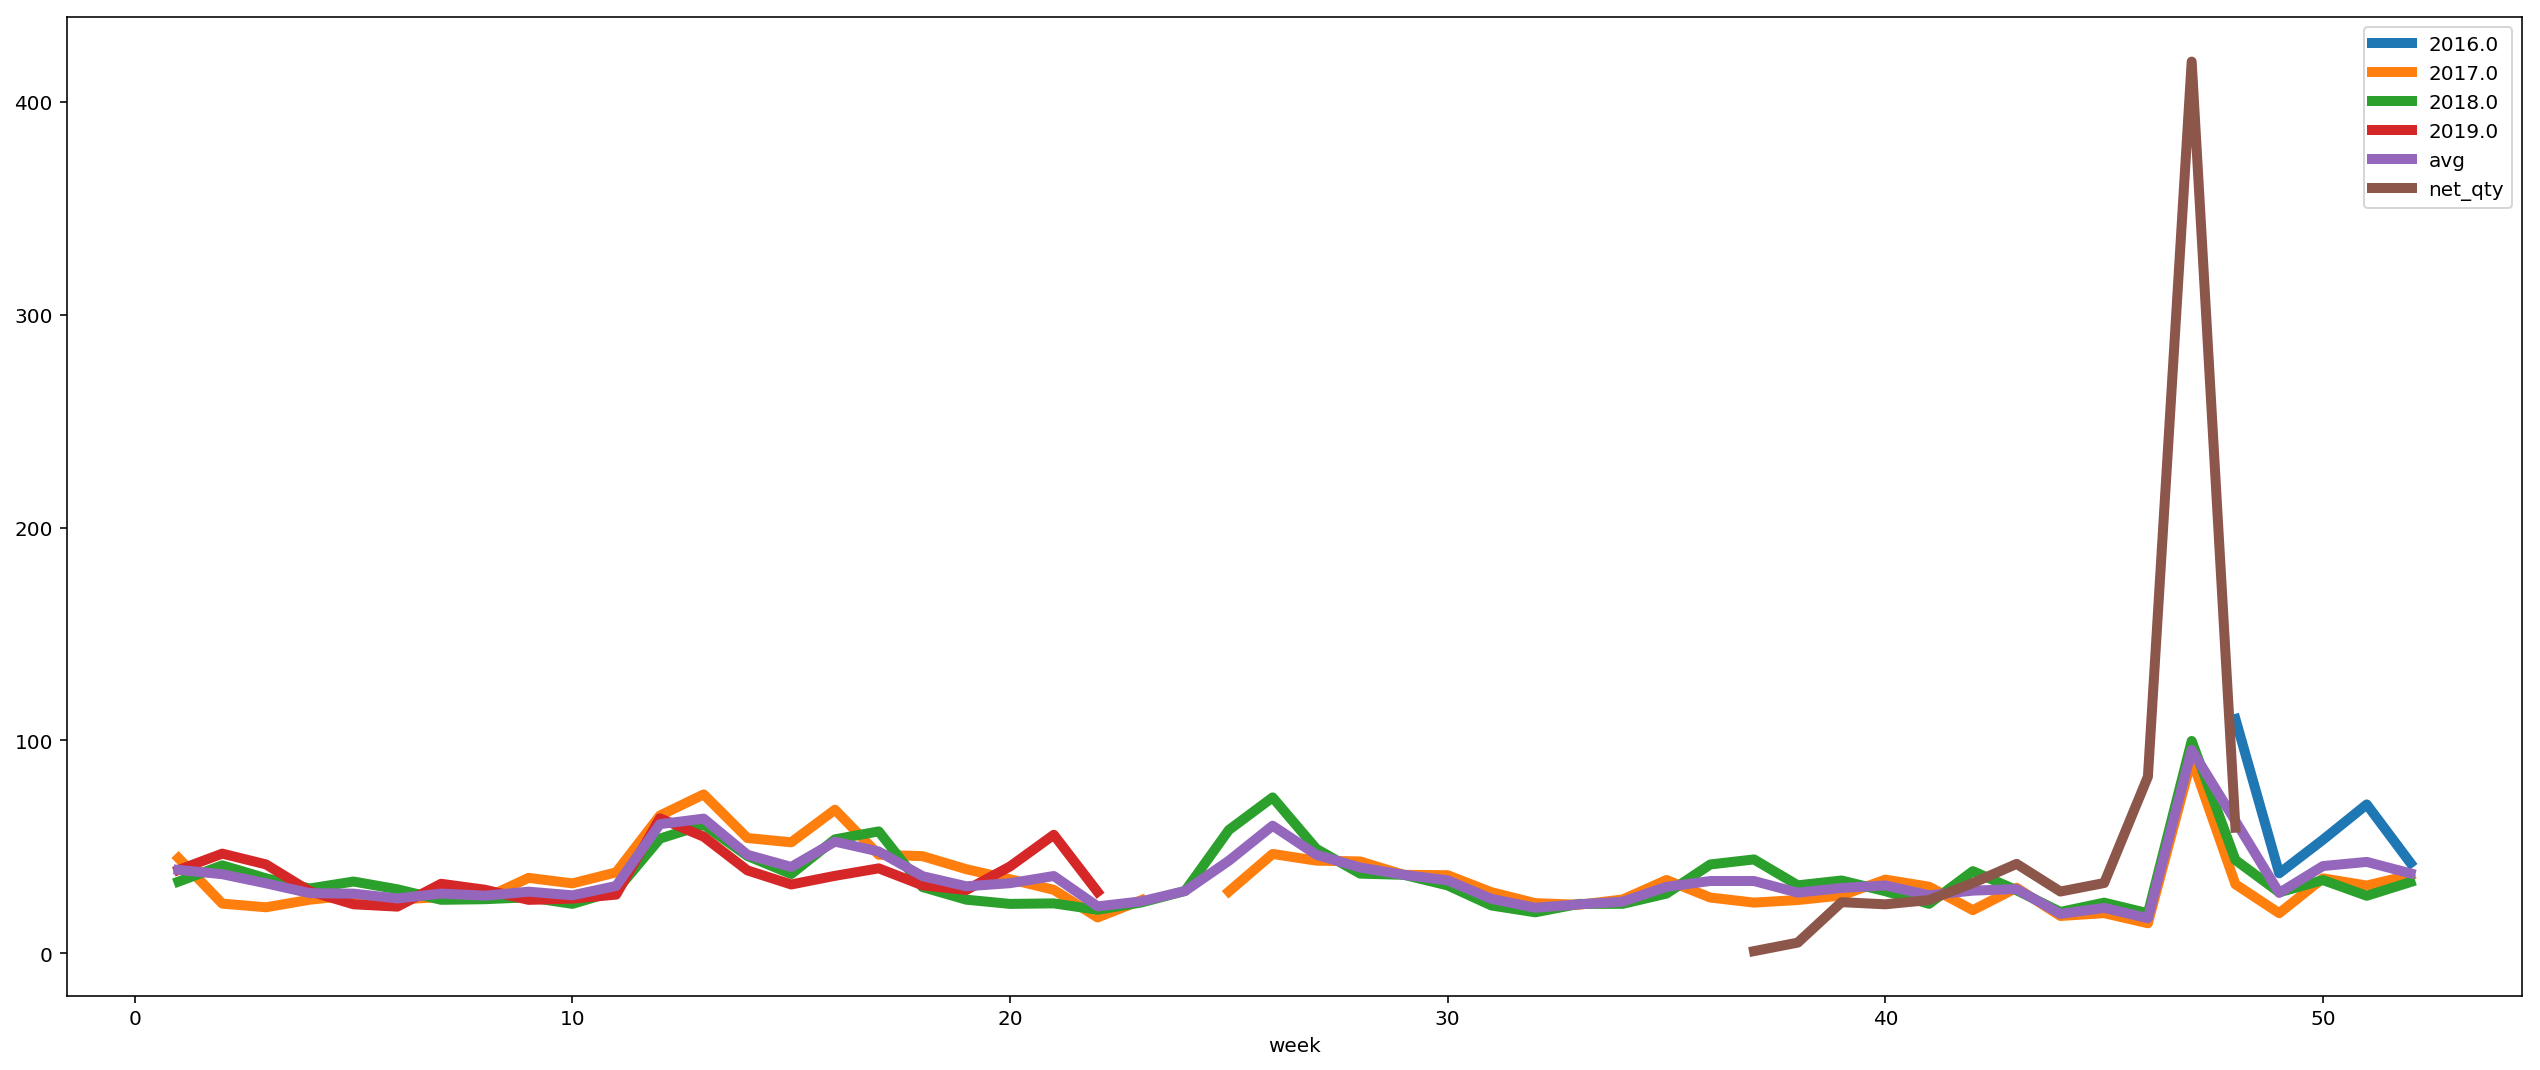

In [65]:
pd.merge(
    pivoted, article[['week','net_qty']], how = 'left', left_index=True, right_on='week'
).set_index('week').plot(linewidth = 5)





# Appendix

In [ ]:

# # ---- Add cost ----
# cost_price = pd.read_csv('Cost Price.csv', low_memory=False, index_col = 0)
# cost_price.rename(columns = {'avg(cost_of_sales)': 'cost'}, inplace = True)
# cost_price = pd.DataFrame(cost_price['cost'].groupby(cost_price.index).mean()).round()


In [ ]:
# dat.drop(['plant', 'warehouse'], axis = 1, inplace=True)

# dat.buy_availability = dat.buy_availability.round(2)

# dat.drop_duplicates(['article_number', 'consumer_order_date'], inplace = True)

# dat[dat.duplicated()]

In [ ]:
# len(set(dat2[dat2.season == 'FW18'].article_number).intersection(set(dat2[dat2.season == 'FW19'].article_number)))


In [ ]:
# ref_dat.head()

# pd.crosstab(index = ref_dat['rmh_product_type_descr'], columns = 'count')

# for c in ref_dat.columns:
#     d = ref_dat[c].unique()
#     print('***', c, '***', d)

In [ ]:
# ref_dat = pd.read_csv('data/dat_ref.csv', low_memory = False, index_col = 0,
#                      usecols = ['group_article', 'price_band', 'age_group_descr', 
#                                 'brand_descr', 'sub_brand_descr',
#                                 'rmh_retail_department_descr', 'rmh_category_descr', 'rmh_gender_descr',
#                                 'rmh_retail_section_descr', 'rmh_product_division_descr',
#                                 'rmh_product_type_descr', 'product_franchise_descr'])

# ref_dat2 = pd.read_csv('data/Article reference data.csv', low_memory = False, index_col = 0, error_bad_lines = False,
#                       usecols = ['model_no', 'key_cat_desc', 'sports_cat_desc', 'rmh_cat_desc', 
#                                  'prod_div_desc', 'prod_grp_desc', 'prod_type_desc']                      
#                       )



In [ ]:
article = 'G27706'

d = dat[dat['article_number'] == article][['consumer_order_date', 'article_number', 'buy_availability', 'gross_demand_quantity']]

pivoted = d.pivot(index = 'consumer_order_date', columns = 'article_number', values = 'buy_availability')

pivoted2 = d.pivot(index = 'consumer_order_date', columns = 'article_number', values = 'gross_demand_quantity')    

forecasts[forecasts.index == article].round()

d.round(2)
d.gross_demand_quantity.sum()

plt.rcParams["figure.figsize"] = [18,6]

pivoted.plot(linewidth = 4)
plt.title('Buy Availability Over Time')
plt.ylabel('Buy Availability')

pivoted2.plot(linewidth = 4)
plt.title('Weekly Gross Demand Quantity')
plt.ylabel('Gross Demand Quantity')


In [ ]:
import statsmodels.api as sm

mod = sm.OLS(article_s.y, article_s.X, missing='drop') # y = article, x = seasonality
mod_res = mod.fit()

mod_res.summary()

article_s['seasonal_impute'] = mod_res.predict()